# Demonstrator for the "P-Sphere Hull" package

This notebook uses methods from the `refine_cluster_set` module and `PSphereHull` modules to explore and visualize the high-dimensional topology of a dataset, and define a domain around the data that can easily be tested for membership.

__Basic approach__

The new package supports the following procedure to model the domain of a p-dimensional dataset:
1. Cluster the dataset with a high value of k (30-50 usually works well), using any appropriate method. KMeans and Gaussian Mixtures are good for giving quick results. The idea is to subdivide the data into small, convex clusters that respect the local manifold of the data.
2. Choose a simple geometric surface to contain each cluster (p-sphere or p-cylinder). Each surface contains a hypervolume or subdomain that we consider part of the full domain.
3. The "p-sphere hull" is the collection of subdomains. The subdomains intersect, but together they define an envelope that
surrounds the training data and defines the domain of applicability of the model.
4. We presume that the ability of the model to make a "valid" prediction is limited to points inside at least one subdomain. The outermost, low density shells of the p-spheres already include a generous margin around the training data.

__Terminology__

The composite domain is called a *p-sphere hull*, and is modeled by the `PSphereHull` class. 
The sub-domains are generically called *p-spheres*, and they are modeled by the `PSphere` class.
A PSphereHull object contains a collection of PSphere objects. Note that the actual surfaces used
to model the subdomains can be either p-spheres or p-cylinders. (1)

__Advantages__

In practice, a machine learning model can save the p-sphere hull of its training data and *warn users* if it tries to make a prediction from a vector outside the hull. This is a more direct and useful way of detecting model drift than tracking an aggregated performance metric. (2)

The p-sphere hull can be created with the training data alone, in parallel with and independent from the workstream of predictive modeling. When an AI application is deployed, the p-sphere hull can be used as a filter on new data upstream of the AI. This approach allows us to test new points for membership in the p-sphere hull very quickly, adding no significant computational overhead to the cost of developing and running a machine learning application. (3)

In practice, if the topology of the training data is relatively simple then the p-sphere hull can be considered an approximation to the convex hull, but one that is much easier to create and apply. The overlapping p-spheres create an approximately convex outer envelope around the main point cloud.  On the other hand, if the topology of the training data is complex, then you can use the methods defined in this library to refine the initial set of clusters and arrive at a collection of subdomains that follows closely the low-dimensional excursions and gaps in the data.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Footnotes,-dependencies,-and-imports" data-toc-modified-id="Footnotes,-dependencies,-and-imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Footnotes, dependencies, and imports</a></span></li><li><span><a href="#Load-and-Visualize-a-Dataset" data-toc-modified-id="Load-and-Visualize-a-Dataset-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load and Visualize a Dataset</a></span></li><li><span><a href="#Cluster-the-Data-and-Refine-the-Cluster-Set" data-toc-modified-id="Cluster-the-Data-and-Refine-the-Cluster-Set-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Cluster the Data and Refine the Cluster Set</a></span><ul class="toc-item"><li><span><a href="#Widget-to-highlight-a-single-cluster" data-toc-modified-id="Widget-to-highlight-a-single-cluster-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Widget to highlight a single cluster</a></span></li><li><span><a href="#Compare-the-clusters-in-terms-of-volume-and-density" data-toc-modified-id="Compare-the-clusters-in-terms-of-volume-and-density-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Compare the clusters in terms of volume and density</a></span></li><li><span><a href="#Improve-individual-clusters" data-toc-modified-id="Improve-individual-clusters-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Improve individual clusters</a></span></li></ul></li><li><span><a href="#Make-the-P-Sphere-Hull" data-toc-modified-id="Make-the-P-Sphere-Hull-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Make the P-Sphere Hull</a></span><ul class="toc-item"><li><span><a href="#Identify-and-mask-redundant-subdomains" data-toc-modified-id="Identify-and-mask-redundant-subdomains-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Identify and mask redundant subdomains</a></span></li><li><span><a href="#Widget-to-display-a-single-cluster-in-3-projections,-with-the-p-sphere-and-p-cylinder-enclosing-it" data-toc-modified-id="Widget-to-display-a-single-cluster-in-3-projections,-with-the-p-sphere-and-p-cylinder-enclosing-it-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Widget to display a single cluster in 3 projections, with the p-sphere and p-cylinder enclosing it</a></span></li><li><span><a href="#Test-whether-new-vectors-are-inside-the-dataset-domain" data-toc-modified-id="Test-whether-new-vectors-are-inside-the-dataset-domain-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Test whether new vectors are inside the dataset domain</a></span></li></ul></li><li><span><a href="#Machine-Learning-with-a-P-Sphere-Hull" data-toc-modified-id="Machine-Learning-with-a-P-Sphere-Hull-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Machine Learning with a P-Sphere Hull</a></span><ul class="toc-item"><li><span><a href="#Traditional-machine-learning-process" data-toc-modified-id="Traditional-machine-learning-process-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Traditional machine learning process</a></span></li><li><span><a href="#Build-a-hull-for-the-training-dataset" data-toc-modified-id="Build-a-hull-for-the-training-dataset-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Build a hull for the training dataset</a></span></li><li><span><a href="#Classification-results:-in-domain-vs-ex-domain-data" data-toc-modified-id="Classification-results:-in-domain-vs-ex-domain-data-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Classification results: in-domain vs ex-domain data</a></span></li><li><span><a href="#Regression-results:-in-domain-vs-ex-domain-data" data-toc-modified-id="Regression-results:-in-domain-vs-ex-domain-data-5.4"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>Regression results: in-domain vs ex-domain data</a></span></li></ul></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Conclusion</a></span></li></ul></div>

## Footnotes, dependencies, and imports

1. Just as a cylinder  is a circle that has been extended by a small amount in the 3rd dimension, a p-cylinder is a spherical surface that has been extended by small amounts in one or more perpendicular dimensions. When using p-cylinders, which is the default behavior, the `PSphere` class uses the PCA and SparsePCA algorithms to detect dimensions that are 'compact' and can be modeled as perpendicular extensions of a sphere. For example, if it detects that 2 out of 6 dimensions are compact, then the surface is a 4-sphere extended by small amounts into the other 2 dimensions. The algorithm to detect compact dimensions has only one tunable parameter: an explained variance threshold (default = 90%) for the principal components.

2. After a model is deployed, the number of points falling outside the training domain may gradually increase as the model impacts the nature of the data being collected. In an aggregated performance metric, we might not see the impact of this drift for months, by which time many unreliable predictions will already have been made. If the model can emit individual warnings, however, then the growing stream of unreliable predictions will be very obvious.

3. We could also build the domain as a collection of convex hulls, simplexes, or PCA-rotated hypercuboids, 
but these alternatives would add significant overhead to the membership test. A future version of this package
will support PCA-rotated hypercuboids, but you are welcome to test these ideas yourself.

This package was developed using:
* sklearn version: 0.23.2
* numpy version 1.19.4
* pandas version 1.0.4
* matplotlib version 2.1.2
* ipywidgets version 7.5.1

In [1]:
%load_ext watermark
%watermark -v -p scikit-learn,numpy,pandas,matplotlib,ipywidgets

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.19.0

scikit-learn: 0.23.2
numpy       : 1.19.2
pandas      : 1.1.3
matplotlib  : 3.3.2
ipywidgets  : 7.5.1



In [2]:
%matplotlib inline

# import libraries
import numpy as np
import pandas as pd

# Plotting
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from mpl_toolkits.mplot3d import Axes3D

# Interaction
from ipywidgets import interact, interactive, fixed, interact_manual, interactive_output
import ipywidgets as widgets

# Scikit-learn
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, Birch
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import sklearn.metrics as metrics

In [3]:
# PSphereHull modules

# import PSphereHull package from local folder
import os
import sys
module_path = '..\\src\\'
if module_path not in sys.path:
    sys.path.append(module_path)

from PSphereHull import refine_cluster_set as rcs
from PSphereHull import psphere_hull as psh
from PSphereHull import basic_functions as bf

## Load and Visualize a Dataset

This notebook uses the "CPU small" dataset (https://www.openml.org/d/227) from OpenML to demonstrate the workflow. The original datast has 12 features to predict the number of simultaneous users on a single Sun Sparcstation. To simplify the visualizations, I have removed 3 low-importance features, leaving us with a 9-dimensional dataset. 

In addition, I remove examples with fewer than 10 users because this subset is perfectly predictable from the freeswap feature.

In [4]:
# Read and prepare server load dataset

df_raw = pd.read_csv('../data/dataset_2213_cpu_small.csv', sep=',').applymap(pd.to_numeric)
print('Original file shape')
print(df_raw.shape)

# Drop lines where usr < 10
df_raw = df_raw[df_raw['usr'] >= 10]
print('After dropping usr < 10')
print(df_raw.shape)

# get target variable
target = df_raw['usr'].values
df_raw.drop(['usr'], axis=1, inplace=True)

print('After removing target variable and 3 low-importance features')
data = df_raw.drop(['lread','lwrite','runqsz'], axis=1)
print(data.shape)

# De-correlate a pair
data['sread_swrite_mean'] = 0.5 * (data['sread'] + data['swrite'])
data['sread_swrite_delta'] = data['sread'] - data['swrite']

# De-corrleate a pair
data['exec_fork_mean'] = 0.5 * (data['exec'] + data['fork'])
data['exec_fork_delta'] = data['exec'] - data['fork']

# Drop original columns
data.drop(['sread','swrite','exec','fork'], axis=1, inplace=True)

# apply Standard scaler
print('Standard Scaler')
ss = StandardScaler()
scaled_data = ss.fit_transform(data)
print(scaled_data.shape)
data.head()

Original file shape
(8192, 13)
After dropping usr < 10
(7898, 13)
After removing target variable and 3 low-importance features
(7898, 9)
Standard Scaler
(7898, 9)


,scall,rchar,wchar,freemem,freeswap,sread_swrite_mean,sread_swrite_delta,exec_fork_mean,exec_fork_delta
0,1036,172076,355965,6527,1851864,108.5,-11,1.000,0.00
1,2165,43107,44139,130,1131931,153.0,104,0.800,0.80
2,3806,492142,268706,256,1314590,212.0,92,1.400,0.00
3,4721,524787,174964,233,972606,216.5,79,1.785,1.59
4,3949,197289,529200,331,1013805,246.5,5,3.600,2.00


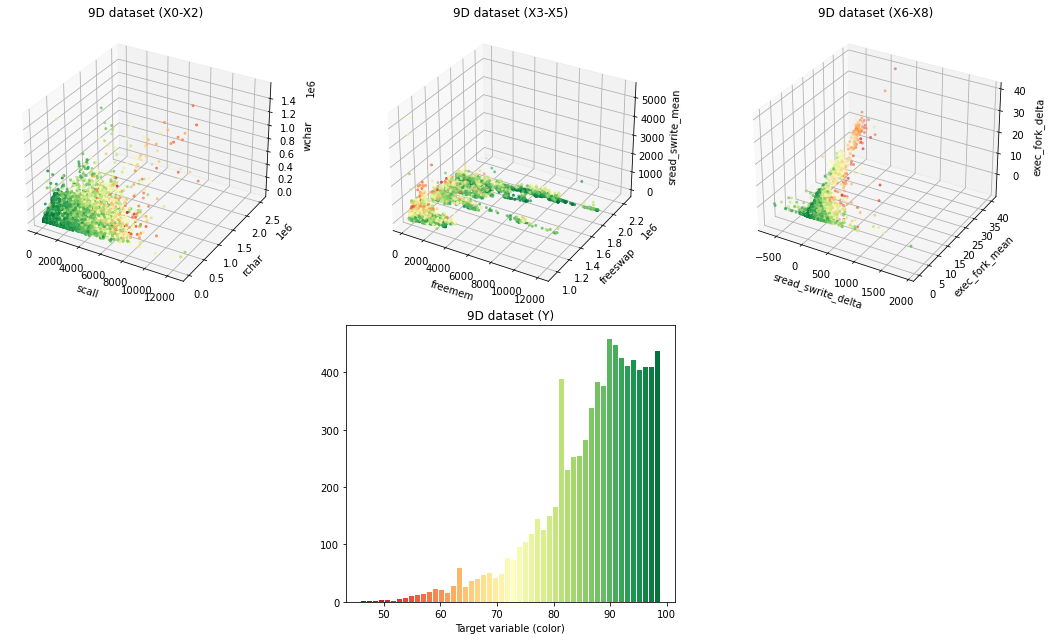

In [5]:
# plot the scaled dataset as three 3D projections and the target variable

colormap = cm.RdYlGn #or any other colormap
normalize = colors.Normalize(vmin=np.min(target), vmax=np.max(target))
s_map = cm.ScalarMappable(norm=normalize, cmap=colormap)

fig = plt.figure(figsize=(15,9))

ax = fig.add_subplot(231, projection='3d')
ax.set_xlabel(data.columns[0])
ax.set_ylabel(data.columns[1])
ax.set_zlabel(data.columns[2])
ax.set_title('9D dataset (X0-X2)')
ax.scatter(data.values[:,0],data.values[:,1],data.values[:,2], s=4, 
           c=target, cmap=colormap, norm=normalize)

ax = fig.add_subplot(232, projection='3d')
ax.set_xlabel(data.columns[3])
ax.set_ylabel(data.columns[4])
ax.set_zlabel(data.columns[5])
ax.set_title('9D dataset (X3-X5)')
ax.scatter(data.values[:,3],data.values[:,4],data.values[:,5], s=4,
          c=target, cmap=colormap, norm=normalize)

ax = fig.add_subplot(233, projection='3d')
ax.set_xlabel(data.columns[6])
ax.set_ylabel(data.columns[7])
ax.set_zlabel(data.columns[8])
ax.set_title('9D dataset (X6-X8)')
ax.scatter(data.values[:,6],data.values[:,7],data.values[:,8], s=4,
          c=target, cmap=colormap, norm=normalize)

ax = fig.add_subplot(235)
vals, bins = np.histogram(target, bins=50)
bar_colors = s_map.to_rgba(bins)
ax.bar(bins[:-1], vals, align='edge', color=bar_colors[:-1])
ax.set_xlabel('Target variable (color)')
ax.set_title('9D dataset (Y)')
#ax.set_xlim((0,20))

fig.tight_layout()
#fig.savefig('9D_cpu_dataset_with_target.png')

## Cluster the Data and Refine the Cluster Set

The end goal of this process is to find a "balanced" set of clusters whose bounding surfaces do not contain much excess
hypervolume. Specifically, the default behavior is to create a collection of p-cylinders that combine to make the 
"p-sphere hull" of the whole dataset.

The package `refine_cluster_set` provides a set of tools that you can use to compare the clusters, identifying
those which are very sparse or low-dimensional with respect to the feature space, and modify the clusters by splitting them,
fusing them, or removing outliers that inflate the volume.

The new package is agnostic to the clustering method used on the data. The methods in this package
only take the dataset, cluster labels, and cluster centers as inputs, not the trained model. 
Note that above, we applied the `StandardScaler()` transform to the data values. 

Here we use Gaussian mixtures to find the initial cluster set.   

Note that `K-means(2)` is used by the method `rcs.split_cluster()` to divide a large cluster into 2 smaller clusters.

In [6]:
# Gaussian mixtures, k-means, or any other method
n_clusters = 40
gm = GaussianMixture(n_clusters, random_state=42)
gm_labels = gm.fit_predict(scaled_data)

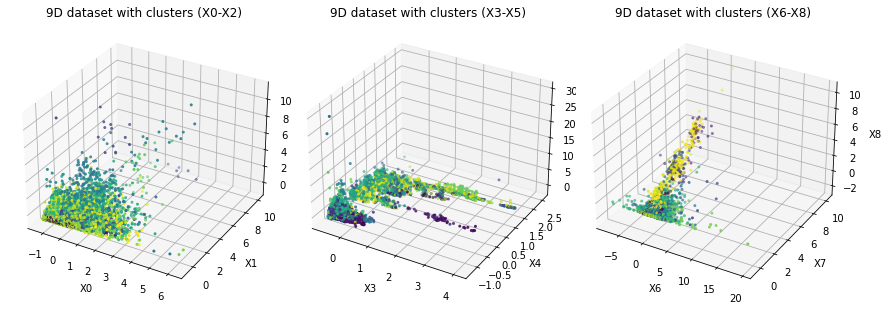

In [7]:
# A set of 3D plots where color indicates cluster membership
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(131, projection='3d')
ax.set_xlabel('X0')
ax.set_ylabel('X1')
ax.set_zlabel('X2')
ax.set_title('9D dataset with clusters (X0-X2)')
ax.scatter(scaled_data[:,0], scaled_data[:,1], scaled_data[:,2], s=4, c=gm_labels)
ax = fig.add_subplot(132, projection='3d')
ax.set_xlabel('X3')
ax.set_ylabel('X4')
ax.set_zlabel('X5')
ax.set_title('9D dataset with clusters (X3-X5)')
ax.scatter(scaled_data[:,3], scaled_data[:,4], scaled_data[:,5], s=4, c=gm_labels)
ax = fig.add_subplot(133, projection='3d')
ax.set_xlabel('X6')
ax.set_ylabel('X7')
ax.set_zlabel('X8')
ax.set_title('9D dataset with clusters (X6-X8)')
ax.scatter(scaled_data[:,6], scaled_data[:,7], scaled_data[:,8], s=4, c=gm_labels)
fig.tight_layout()
#fig.savefig('9D_cpu_dataset_initial_clustering.png') 

### Widget to highlight a single cluster

Clusters 16 and 17 give are nice examples of how points can be "close together" in one projection 
but "dispersed" in another. On some level we must trust that the clustering method can identify
points that are truly close, but for very high-dimensional problems manifold learning might be
needed to guarantee that clusters are close with respect to their local manifold, rather than with
respect to Euclidean distance.

In [8]:
# define display_cluster() function for widget
col_names = data.columns.tolist()
def display_cluster_1(cluster_id):
    fig = plt.figure(figsize=(12,5))
    ic_colors = np.where(gm_labels == cluster_id, 'red', 'grey')
    ic_sizes = np.where(gm_labels == cluster_id, 9, 1)
    ax = fig.add_subplot(131, projection='3d')
    ax.set_xlabel(col_names[0])
    ax.set_ylabel(col_names[1])
    ax.set_zlabel(col_names[2])
    ax.set_title('Cluster '+str(cluster_id))
    ax.scatter(scaled_data[:,0],scaled_data[:,1],scaled_data[:,2], s=ic_sizes,
              c=ic_colors)
    ax = fig.add_subplot(132, projection='3d')
    ax.set_xlabel(col_names[3])
    ax.set_ylabel(col_names[4])
    ax.set_zlabel(col_names[5])
    ax.set_title('Cluster '+str(cluster_id))
    ax.scatter(scaled_data[:,3],scaled_data[:,4],scaled_data[:,5], s=ic_sizes,
              c=ic_colors)
    ax = fig.add_subplot(133, projection='3d')
    ax.set_xlabel(col_names[6])
    ax.set_ylabel(col_names[7])
    ax.set_zlabel(col_names[8])
    ax.set_title('Cluster '+str(cluster_id))
    ax.scatter(scaled_data[:,6],scaled_data[:,7],scaled_data[:,8], s=ic_sizes,
              c=ic_colors)
    fig.tight_layout()
    plt.show()
    return

In [9]:
inbox = widgets.BoundedIntText(value=0, min=0, max=n_clusters-1, description='Cluster ID:')
ui = widgets.HBox([inbox])
# cluster_id is the name of an argument to f()
out = widgets.interactive_output(display_cluster_1, {'cluster_id': inbox})
display(ui,out);

Output()

### Compare the clusters in terms of volume and density

The first method we want to use from `refine_cluster_set` is `rcs.describe_cluster_pspheres()`. It generates a pandas dataframe of useful statistics to compare the clusters and help us decide which ones might need adjusting.

For each cluster, it finds the p-box (a hypercuboid) and p-cylinder that surround its data, then calculates the volume of the shape and the density of data within. It also uses Principal Component Analysis to calculate the 'local
dimensionality' of the data manifold: the number of principal components that explain 90% of the variance.

The columns of the dataframe are:
* ndata: number of data points in cluster
* localdim: number of principal components that explain pct_threshold of cluster variance
* radius: the radius of the spherical part of the p-cylinder
* ps_volume: hypervolume inside the p-cylinder bounding the cluster
* ps_vratio: ps_volume / full dataset hypervolume
* ps_density: ndata / ps_volume
* hc_volume: hypervolume inside the p-box bounding the cluster 
* hc_vratio: hc_volume / full dataset hypervolume
* hc_density: ndata / hc_volume
* ps_to_hc: ps_volume / hc_volume

In [10]:
spheres_df = rcs.describe_cluster_pspheres(scaled_data, gm_labels, gm.means_)

# Alternatively, you can calculate p-sphere volumes instead of p-cylinder volumes:
#spheres_df = rcs.describe_cluster_pspheres(scaled_data, gm_labels, gm.means_, use_pcylinders=False)

spheres_df

Note: ps_density, ps_volume, ps_vratio, and ps_to_hc are using p-cylinder volumes


,ndata,localdim,radius,ps_volume,ps_vratio,ps_density,hc_volume,hc_vratio,hc_density,ps_to_hc
cluster,,,,,,,,,,
0,408,5,1.499722,5.811477e-02,2.637056e-11,7.020590e+03,3.452911e-03,1.566816e-12,1.181612e+05,16.830663
1,98,4,4.311650,5.984107e+05,2.715389e-04,1.637671e-04,4.639114e+03,2.105076e-06,2.112472e-02,128.992443
2,258,5,2.514792,3.485467e+03,1.581589e-06,7.402165e-02,1.875770e+02,8.511622e-08,1.375435e+00,18.581524
3,37,4,4.138583,4.597303e+03,2.086104e-06,8.048196e-03,1.458039e+02,6.616098e-08,2.537655e-01,31.530724
4,216,4,2.229182,4.399197e+01,1.996210e-08,4.909987e+00,5.591494e-01,2.537235e-10,3.863010e+02,78.676587
5,97,3,3.920094,3.544343e+02,1.608305e-07,2.736756e-01,2.009412e+01,9.118043e-09,4.827284e+00,17.638708
6,211,4,3.693013,1.070571e+04,4.857895e-06,1.970911e-02,2.440543e+02,1.107437e-07,8.645618e-01,43.866095
7,73,5,4.728588,2.318414e+04,1.052019e-05,3.148704e-03,3.760998e+02,1.706616e-07,1.940974e-01,61.643589
8,13,4,5.949152,3.278252e+06,1.487562e-03,3.965528e-06,2.043576e+04,9.273072e-06,6.361396e-04,160.417395


After creating the dataframe with `rcs.describe_cluster_pspheres()`, the method `rcs.plot_cluster_pspheres()` lets you
produce log-log plots of the cluster statistics. This plot highlight clusters that are large and sparse or low-dimensional.

The sizes of the markers are scaled so that area is proportional to ndata. The colors of the markers indicate the local dimensionality of the cluster: red for zero-dimensional or one-dimensional clusters, orange for two-dimensional clusters, 
and so on.

In the cell below, recall that the horizontal axis is the log of the p-cylinder volume expressed as a fraction of the hypercube volume defined by the feature ranges, so a value of -2 indicates that the p-cylinder volume is 1% of the hypercube volume.

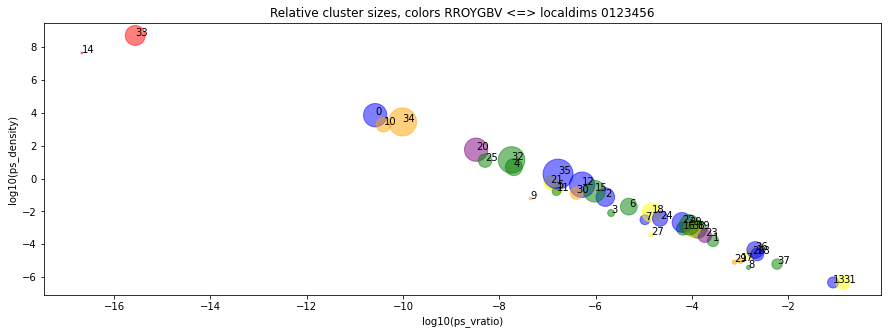

In [11]:
rcs.plot_cluster_pspheres(spheres_df, 6, 'ps_vratio', 'ps_density')

# Alternatively, add a filename argument to save the figure:

#fig_title = '6D_industrial_dataset_initial_pspheres_plot.png'
#rcs.plot_cluster_pspheres(spheres_df, 6, 'ps_vratio', 'ps_density', filename=fig_title)

By looking at this plot, we can see immediately which clusters are likely to contain a lot of wasted volume. If the 
local dimension of a cluster is much less than $p$ (for example, a linear cluster in a 4D space) then the bounding 
surface contains a lot of wasted space and does not represent well the cluster shape. Using p-cylinders instead of 
p-spheres (the default behavior) mitigates this risk but does not remove it entirely.

Clusters 13 and 31 are both low-dimensional (localdim=3) and high-volume, so can be considered at risk of contributing excessive volume to the domain model.

Linear clusters can also be split recursively (see below).

Another common feature highlighted by this plot is that some clusters are large and sparse (lower right region of the plot).
In some cases, the hypervolume of the p-sphere bounding a cluster can even be larger than the hypercuboid that bounds the 
full dataset.

### Improve individual clusters

We want to improve the clustering solution by reducing the wasted hypervolume in the p-cylinders that will represent subdomains of the dataset.

A sparse cluster may be "improved" by two methods: 
* `rcs.flag_outlier()` removes the data point with the largest radius by changing its cluster label to -1
* `rcs.split_cluster()` using KMeans(2) to create two subclusters
The list of labels and cluster centers is updated accordingly; you can end up with more clusters than you started with.

For the sake of symmetry, there is also a method `rcs.fuse_clusters()` that you can use if you notice two compact clusters
that are very close together. However, `split_cluster` and `fuse_clusters` are not reciprocal operations because the process of splitting has a random element.

The following cells describe my own decision process to refine this cluster set.

__Cluster 13 is sparse and appears to cover most of the dataset__

Recall that you can use the widget in cell 9 to visualize any individual cluster.

The danger is that the bounding surface of this cluster has a very large hypervolume, which includes regions empty 
of data and will obscure some of the interesting geometry of the dataset. The value of log10(ps_vratio) is about 0.1, 
meaning that the p-cylinder volume occupies about 10% of
the hypercuboid volume of the full dataset! (However, note that some of this volume lies outside the original hypercube)

Note that the first function call of split_cluster uses the original K-means labels and centers, but the following operations
rewrite the variables new_labels and new_centers.

In [12]:
cid = 13
new_labels, new_centers, success = rcs.split_cluster(scaled_data, gm_labels, gm.means_, cid, min_size=4, verbose=True)
print(new_centers.shape)

......cluster 13 split successfully
(41, 9)


__Cluster 31 is small and sparse__

The next sparsest cluster is number 31, which also has some outliers visible in the 3D projections. Removing a couple of outliers can greatly decrease the enclosed volume.

Note that the arguments to `split_cluster()` and `flag_outlier()` are now the arrays `new_labels` and `new_centers`; each operation updates the previous clustering solution.

In [13]:
cid = 31
new_labels, new_centers, success = rcs.split_cluster(scaled_data, new_labels, new_centers, cid, min_size=4, verbose=True)
new_labels = rcs.flag_outlier(scaled_data, new_labels, new_centers, cid)
new_labels = rcs.flag_outlier(scaled_data, new_labels, new_centers, cid)
print(new_centers.shape)

......cluster 31 split successfully
(42, 9)


__Cluster 33 is 1-dimensional__

This cluster has a local dimensionality of 1 and contains a lot of data (296 points). We can use the method
`refine_linear_clusters()` to recursively subdivide it. 

Note, however, that the p-cylinder volume is already one of the lowest--cluster 33 appears in the upper left corner of the plot. This is because the cluster's axis is aligned with a feature axis. I will split it anyway as a demonstration, but the method is mainly useful if a dataset contains a linear subdomain that is not well aligned with the feature axes. In such a scenario,
then `refine_linear_clusters()` can change a single large p-sphere into a "string of beads" along the subdomain.

This method is applied to the whole dataset, not to a single cluster.

In [14]:
new_labels, new_centers = rcs.refine_linear_clusters(scaled_data, new_labels, new_centers, verbose=True)
print(new_centers.shape)

Running split_all_linear_clusters, clusters to test: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41]
......split_cluster: min_size is larger than cluster to split
......cluster 33 split successfully
...created new cluster 33 with center [-1.30153874 -0.7988373  -0.61592595  2.81185557  1.4281432  -0.93504971
 -0.66925343 -0.58475286 -0.24778585]
Running split_all_linear_clusters, clusters to test: [33, 42]
......cluster 42 split successfully
...created new cluster 42 with center [-1.30158112 -0.79734843 -0.6036614   2.673755    1.42201294 -0.93328347
 -0.67871626 -0.5857072  -0.24778585]
Running split_all_linear_clusters, clusters to test: [42, 43]
......cluster 42 split successfully
...created new cluster 42 with center [-1.310102   -0.80368835 -0.65023476  4.04795014  1.48963117 -0.96718554
 -0.62936109 -0.5857072  -0.24778585]
Running split_all_linear_clusters, clusters to 

Let's take another look at the p-cylinder volumes for the new cluster set:

Note: ps_density, ps_volume, ps_vratio, and ps_to_hc are using p-cylinder volumes


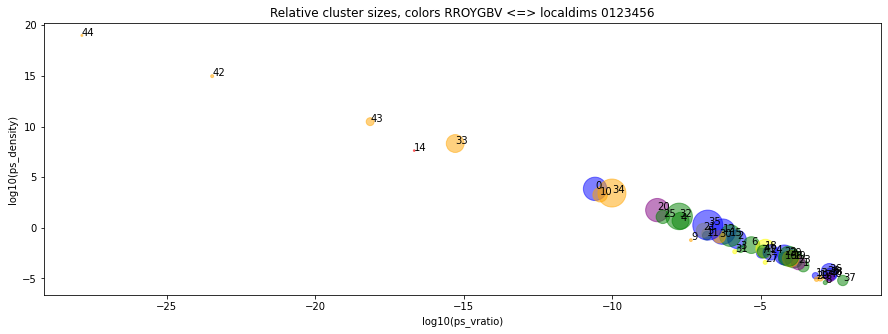

In [15]:
# Notice that we pass the new_labels and new_centers as arguments to describe_cluster_pspheres

spheres_df = rcs.describe_cluster_pspheres(scaled_data, new_labels, new_centers)
rcs.plot_cluster_pspheres(spheres_df, 6, 'ps_vratio', 'ps_density')

The high-volume spheres are hard to distinguish in this plot, so let's take a look at the 10 most voluminous clusters

In [16]:
top_ten_idx = spheres_df.ps_vratio.values.argsort()[::-1][:10]
spheres_df.loc[top_ten_idx]

,ndata,localdim,radius,ps_volume,ps_vratio,ps_density,hc_volume,hc_vratio,hc_density,ps_to_hc
cluster,,,,,,,,,,
37,81,4,5.395515,1.278244e+07,0.005800,0.000006,30241.807334,0.000014,0.002678,422.674419
28,123,5,5.419383,4.975857e+06,0.002258,0.000025,7394.551384,0.000003,0.016634,672.908599
40,62,6,4.824413,4.670011e+06,0.002119,0.000013,262370.188682,0.000119,0.000236,17.799319
36,206,5,4.804313,4.497794e+06,0.002041,0.000046,12598.181489,0.000006,0.016352,357.019284
26,106,3,7.841176,3.890006e+06,0.001765,0.000027,11002.359166,0.000005,0.009634,353.561109
8,13,4,5.949152,3.278252e+06,0.001488,0.000004,20435.764658,0.000009,0.000636,160.417395
17,23,2,10.367499,2.233208e+06,0.001013,0.000010,18691.891896,0.000008,0.001230,119.474710
29,14,2,9.227604,1.670027e+06,0.000758,0.000008,4419.293466,0.000002,0.003168,377.894488
13,29,5,4.601661,1.528118e+06,0.000693,0.000019,36020.159380,0.000016,0.000805,42.423963


__Clusters with large volumes__

Based on the above table, a few clusters have relatively large volumes so are worth a closer look using the display widget in cell 9:

* Cluster 37 looks trimodel in the 'freeswap' variable, which might be preventing it from finding freeswap as a compact dimension. We can try splitting it to see if the local dimensionality of one of its subclusters decreases.
* Cluster 28 looks reasonably uniform in all features, with no obvious outliers. However, it has a similar problem to cluster 37 in that it crosses over the obvious subdomains in the freeswap variable, so if we leave it alone its large radius might obscure that aspect of the topology. Therefore we will try splitting it as well.
* Cluster 36 contains 206 points and its local dimensionality is relatively high (5); we can try removing one or two outliers to reduce the radius of the non-compact dimensions.
* Cluster 26 has only 106 points and its local dimensionality is already low (3). No obvious outliers are visible in the widget, so we will leave this one alone.

In [17]:
# split cluster 37
new_labels, new_centers, success = rcs.split_cluster(scaled_data, new_labels, new_centers, 37, verbose=True)
# split cluster 28
new_labels, new_centers, success = rcs.split_cluster(scaled_data, new_labels, new_centers, 28, verbose=True)
# remove two outliers from cluster 36
new_labels = rcs.flag_outlier(scaled_data, new_labels, new_centers, 36)
new_labels = rcs.flag_outlier(scaled_data, new_labels, new_centers, 36)

......cluster 37 split successfully
......cluster 28 split successfully


Let's look at the new set of clusters. Notice that we now have 47 clusters since several clusters from the 
initial Gaussian Mixtures solution were split successfully.
The hypervolumes of all the modified clusters are now much smaller.

If any problematic clusters remain, we can show them to the domain experts and decide together whether to include them in the training data or mask them. The `PSphereHull` class, which we will demonstrate next, allows us to easily make either decision, by setting the boolean atrribute 'used' for a single cluster's domain. 

In [18]:
spheres_df = rcs.describe_cluster_pspheres(scaled_data, new_labels, new_centers)
spheres_df

Note: ps_density, ps_volume, ps_vratio, and ps_to_hc are using p-cylinder volumes


,ndata,localdim,radius,ps_volume,ps_vratio,ps_density,hc_volume,hc_vratio,hc_density,ps_to_hc
cluster,,,,,,,,,,
0,408,5,1.499722,5.811477e-02,2.637056e-11,7.020590e+03,3.452911e-03,1.566816e-12,1.181612e+05,16.830663
1,98,4,4.311650,5.984107e+05,2.715389e-04,1.637671e-04,4.639114e+03,2.105076e-06,2.112472e-02,128.992443
2,258,5,2.514792,3.485467e+03,1.581589e-06,7.402165e-02,1.875770e+02,8.511622e-08,1.375435e+00,18.581524
3,37,4,4.138583,4.597303e+03,2.086104e-06,8.048196e-03,1.458039e+02,6.616098e-08,2.537655e-01,31.530724
4,216,4,2.229182,4.399197e+01,1.996210e-08,4.909987e+00,5.591494e-01,2.537235e-10,3.863010e+02,78.676587
5,97,3,3.920094,3.544343e+02,1.608305e-07,2.736756e-01,2.009412e+01,9.118043e-09,4.827284e+00,17.638708
6,211,4,3.693013,1.070571e+04,4.857895e-06,1.970911e-02,2.440543e+02,1.107437e-07,8.645618e-01,43.866095
7,73,5,4.728588,2.318414e+04,1.052019e-05,3.148704e-03,3.760998e+02,1.706616e-07,1.940974e-01,61.643589
8,13,4,5.949152,3.278252e+06,1.487562e-03,3.965528e-06,2.043576e+04,9.273072e-06,6.361396e-04,160.417395


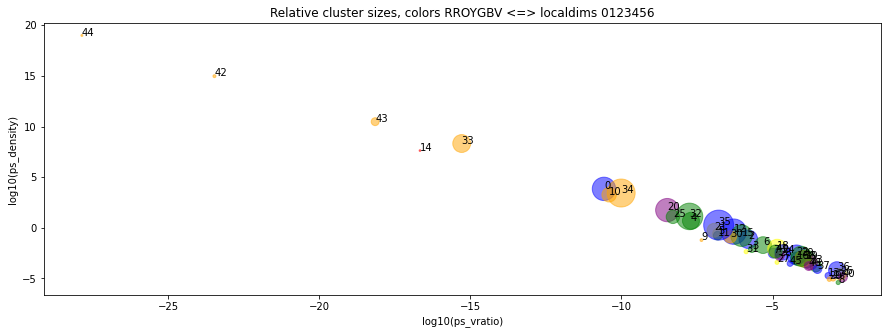

In [19]:
rcs.plot_cluster_pspheres(spheres_df, 6, 'ps_vratio', 'ps_density')

In [20]:
# define display_new_cluster() function for the widget
def display_new_cluster_2(cluster_id):
    col_names = data.columns.tolist()
    fig = plt.figure(figsize=(14,5))
    ic_colors = np.where(new_labels == cluster_id, 'red', 'grey')
    ic_sizes = np.where(new_labels == cluster_id, 9, 1)
    ax = fig.add_subplot(131, projection='3d')
    ax.set_xlabel(col_names[0])
    ax.set_ylabel(col_names[1])
    ax.set_zlabel(col_names[2])
    ax.set_title('Cluster '+str(cluster_id))
    ax.scatter(scaled_data[:,0],scaled_data[:,1],scaled_data[:,2], s=ic_sizes,
              c=ic_colors)
    ax = fig.add_subplot(132, projection='3d')
    ax.set_xlabel(col_names[3])
    ax.set_ylabel(col_names[4])
    ax.set_zlabel(col_names[5])
    ax.set_title('Cluster '+str(cluster_id))
    ax.scatter(scaled_data[:,3],scaled_data[:,4],scaled_data[:,5], s=ic_sizes,
              c=ic_colors)
    ax = fig.add_subplot(133, projection='3d')
    ax.set_xlabel(col_names[6])
    ax.set_ylabel(col_names[7])
    ax.set_zlabel(col_names[8])
    ax.set_title('Cluster '+str(cluster_id))
    ax.scatter(scaled_data[:,6],scaled_data[:,7],scaled_data[:,8], s=ic_sizes,
              c=ic_colors)
    fig.tight_layout()
    plt.show()
    return

In [21]:
inbox = widgets.BoundedIntText(value=0, min=0, max=spheres_df.shape[0], description='Cluster ID:')
ui = widgets.HBox([inbox])
# cluster_id is the name of an argument to f()
out = widgets.interactive_output(display_new_cluster_2, {'cluster_id': inbox})
display(ui,out);

Output()

## Make the P-Sphere Hull

The `PSphereHull` class creates a collection of p-cylinders (default behavior) or p-spheres from a clustering solution: the dataset, the cluster labels, and the cluster centers.

Once the hull is created, several methods are immediately available to test whether a new point is contained in the hull or not. This test is very fast, since the new point is contained by the hull if it is contained in any subdomain. The main advantage of
using p-spheres and p-cylinders is that the mathematical operations needed to test containment are very cheap.

*Note: We could create a "p-box hull" of the hypercuboid subdomains with even less wasted volume. However, then many more points in the dataset would be on the domain boundary and the hull would be less useful overall in an industrial setting where the data are expected to be noisy. I consider p-cylinders to be a good compromise between limiting the enclosed volume while giving the dataset hull a reasonable probability to include noisy and new data.*

In [22]:
%%time
hull = psh.PSphereHull(scaled_data, new_labels, new_centers, compute_all=False)

Wall time: 4.71 s


The following plot shows that p-cylinder envelopes are usually 1-3 orders of magnitude smaller than p-sphere envelopes.

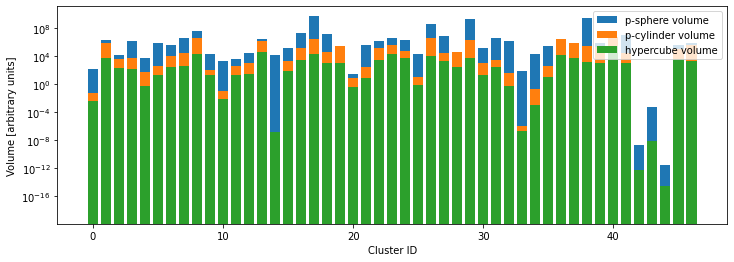

In [23]:
# Plot of p-sphere, p-cylinder, and hypercuboid volumes for the final clustering solution.
labels = [s.label for s in hull.spheres]
vols = [s.volume for s in hull.spheres]
pvols = [s.pcylinder_vol for s in hull.spheres]
hcvols = spheres_df['hc_volume'].values.tolist()
fig = plt.figure(figsize=(12,4))
p1 = plt.bar(labels, vols, log=True)
p2 = plt.bar(labels, pvols, log=True)
p3 = plt.bar(labels, hcvols, log=True)
plt.ylabel('Volume [arbitrary units]')
plt.xlabel('Cluster ID')
plt.legend((p1[0], p2[0], p3[0]), ('p-sphere volume', 'p-cylinder volume', 'hypercube volume'));
#fig.savefig('6D_industrial_dataset_pcylinder_volumes.png')

The following cell shows the 'naive' volume calculation for the whole dataset, which just sums up the volumes of the subdomains while ignoring the fact that many of them overlap. It also shows the 'sampled' volume calculation, which generates random points in the full dataset hypercuboid and reports the fraction that fall inside the hull. The `compute_all` argument above tells the constructor
to calculate both volumes automatically, but you can use the hull without this calculation.

The results show that the p-sphere hull is a much better representation of the data domain than the hypercuboid hull (which is generally the default representation even in industrialized models).

In [24]:
%%time

hull.make_local_dimensions()
hull.make_pcylinders()
hull.make_volume_ratios(n_sample=5000, use_pcylinders=True)

# Display volume ratios for the whole dataset
print('Full dataset hypercube volume:', round(hull.hc_volume,1))
print('---')
print('Naïve p-yclinder vol. ratio: {:6.4f}'.format(hull.naive_pcylinder_vratio))
print('Sampled p-cylinder vol. ratio: {:6.4f} +/- {:6.4f}'.format(hull.sampled_pcylinder_vratio,
                                                                 hull.sampled_pcylinder_vratio_sigma))

Full dataset hypercube volume: 2014999305.9
---
Naïve p-yclinder vol. ratio: 0.0117
Sampled p-cylinder vol. ratio: 0.0016 +/- 0.0006
Wall time: 13.7 s


### Identify and mask redundant subdomains

Many of the clusters have no 'unique' data : every point in the cluster is contained in at least one other cluster's domain. We can represent the hull and test for membership more efficiently if we mask the redundant p-cylinders.

The method `flag_redundant_spheres()` may take up to 5 minutes to run; it scales as $nk^2$. It searches for the highest-volume p-sphere or p-cylinder with no unique points, masks it, then repeats the process until all remaining clusters have unique points.

In [25]:
%%time

hull.flag_redundant_spheres()
print('P-Sphere Hull has masked the following spheres:')
for s in hull.spheres:
    if not s.used:
        print (s.label, end=' ')
print('')

P-Sphere Hull has masked the following spheres:
0 1 2 4 5 6 10 12 15 19 20 21 22 23 24 25 28 30 32 33 34 35 37 39 41 42 43 44 46 
Wall time: 4min 52s


The plot below draws the non-redundant p-cylinders in five 2-dimensional projections of the data.

The code for the plot makes use of the method `rcs.pcylinder_patch`, which returns a circle or rectangle pyplot artist patch, as needed for the 2D cross-section of the p-cylinder.

Some notes on the figure:
* The plots are scaled to show the entire p-cylinder, but the training dataset is also constrained by the feature ranges. Therefore the space in the empty quadrants is not truly part of the p-sphere hull. When we use the `contains()`method to test for OOD data, the hull tests for membership in the feature hypercube AND in the collection of p-cylinders.
* As the legend in the lower right subplot indicates, the color of a p-cylinder envelope represents the local dimensionality of the cluster that was used to create it. This is not the same as the number of non-compact dimensions in the p-cylinder.
* The hull is more compact than it appears in this set of 2-D projections, since most of the p-cylinders has some compact dimensions. Recall that by sampling points randomly within the feature hypercube (cell 24), only about 0.2% were contained in the hull.

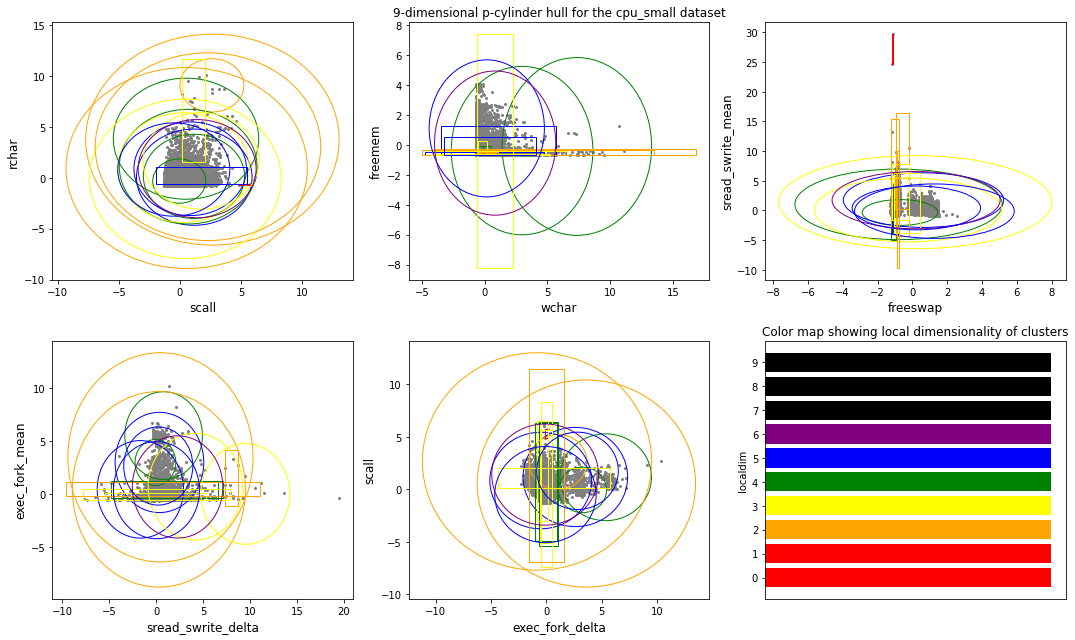

In [26]:
# Code to draw the hull in three 2D projections, using only non-redundant domains
fig = plt.figure(figsize=(15,9))
idx = [[0,1],[2,3],[4,5],[6,7],[8,0]]
dim_map = {0:'red', 1:'red', 2:'orange', 3:'yellow', 4:'green', 5:'blue', 6:'purple', 7:'black', 8:'black', 9:'black'}
clus_cols = [dim_map[i] for i in hull.localdims]
col_names = data.columns.tolist()

for iax in range(5):
    idx1 = idx[iax][0]
    idx2 = idx[iax][1]
    ax = fig.add_subplot(231 + iax)
    ax.set_xlabel(col_names[idx1], size=12)
    ax.set_ylabel(col_names[idx2], size=12)
    ax.scatter(scaled_data[:,idx1], scaled_data[:,idx2], s=4, c='grey')
    for k in range(hull.n_spheres):
        if hull.spheres[k].used:
            cyl, rect = rcs.pcylinder_patch(idx1, idx2, hull.spheres[k].center, hull.spheres[k].radius,
                                            hull.spheres[k].compact_dims, hull.spheres[k].compact_ranges, color=clus_cols[k])
            ax.add_patch(cyl)
    if iax == 1:
        ax.set_title('9-dimensional p-cylinder hull for the cpu_small dataset')

ax = fig.add_subplot(236)
yvals = list(range(10))
ax.tick_params(axis='x', length=0, labelbottom=False)
ax.set_yticks(yvals)
ax.set_ylabel('localdim')
ax.set_title('Color map showing local dimensionality of clusters', size=12)
ax.barh(yvals, [1]*10, color=[dim_map[i] for i in yvals])

fig.tight_layout()        
fig.savefig('9D_cpu_dataset_pcylinders_simplified.png')

### Widget to display a single cluster in 3 projections, with the p-sphere and p-cylinder enclosing it

The following widget can be used to explore the p-sphere hull further. In some cases dimensions that appear compact
are not identified as compact by the algorithm (because one of the sparse PCA components uses that dimension). 
In other cases we can see that one or two outliers are vastly increasing the radius of the spherical part.

It is possible to continue refining the p-sphere hull by hand until it follows the data topology very closely, but with
more than 10 dimensions this kind of analysis becomes unwieldly. For a larger number of dimensions it may be better to
start with a high value of k, say between 50 and 100, so that the clusters have relatively few data points and their
volumes are smaller. 

Keep in mind that you can also choose a cluster, see how many unique points it has, and mask it by hand.

In [27]:
# code to prepare the widget
axmin = []
axmax = []
for icol in range(9):
    axmin.append(np.min(scaled_data[:,icol])-0.3)
    axmax.append(np.max(scaled_data[:,icol])+0.3)
lims = list(zip(axmin,axmax))

def display_cluster_projections(cid):
    fig = plt.figure(figsize=(12,8))
    for iax in range(5):
        ix = iax * 2
        # wrap around to zero
        iy = (iax * 2 + 1) % 9
        ax = fig.add_subplot(231+iax)
        ax.set_xlim(lims[ix])
        ax.set_ylim(lims[iy])
        c_rows = np.where(new_labels==cid)[0]
        ax.scatter(scaled_data[c_rows,ix],scaled_data[c_rows,iy],s=25,marker='x',color='black',lw=0.5, alpha=0.5)
        circ = plt.Circle((hull.spheres[cid].center[ix], hull.spheres[cid].center[iy]),
                              radius=hull.spheres[cid].radius, color=clus_cols[cid], fill=False)
        cyl, rect = rcs.pcylinder_patch(ix, iy, hull.spheres[cid].center, hull.spheres[cid].radius, hull.spheres[cid].compact_dims,
                              hull.spheres[cid].compact_ranges, color='black')
        if rect: 
            ax.add_patch(cyl)
        ax.add_patch(circ)
        if (iax==1):
            ax.set_title('Cluster '+str(cid), size=12)
        ax.set_xlabel(col_names[ix], size=12)
        ax.set_ylabel(col_names[iy], size=12)
    fig.tight_layout()
    plt.show()
    return

In [28]:
inbox = widgets.BoundedIntText(value=0, min=0, max=spheres_df.shape[0], description='Cluster ID:')
ui = widgets.HBox([inbox])
out = widgets.interactive_output(display_cluster_projections, {'cid': inbox})
display(ui,out);

Output()

### Test whether new vectors are inside the dataset domain

The p-sphere hull is now a useful geometric representation of the dataset domain.

The method `hull.contains()` takes a single vector or array of vectors and tests whether each one meets two conditions:
1. The vector is inside any of the hull subdomains.
2. The vector is inside the hypercube defined by the feature ranges.

In this section we are going to generate a completely new dataset within the feature ranges. Testing each new point for membership in the hull takes about 1 ms.

In [29]:
# Generate 500 random data points inside the hypercuboid of the full dataset
ndata = 1000
np.random.seed(499)
newdata = np.zeros(ndata*hull.pdim).reshape((ndata,hull.pdim))
# Each feature has a different scale and offset
for idx in range(hull.pdim):
    scale = hull.hc_max[idx] - hull.hc_min[idx]
    offset = hull.hc_min[idx]
    newdata[:,idx] = (np.random.rand(ndata)*scale) + offset
print('newdata has shape',newdata.shape)
print('example vector:')
print(newdata[0,:])

newdata has shape (1000, 9)
example vector:
[ 5.83380305  5.84113272  7.76289409  1.42654348  1.5324128  24.14829281
 17.01496541  4.04587304  4.71587358]


In [30]:
%%time

point_in_hull = hull.contains(newdata)
points_inside = np.where(point_in_hull)[0]
points_outside = np.where(point_in_hull==False)[0]
print('The new data points that are inside the hull have indices:')
print(points_inside)

The new data points that are inside the hull have indices:
[  2 200 349 504 683]
Wall time: 1.1 s


You can also measure the distances of points from each sphere in the hull. A value of zero indicates that the point is inside the sphere.

The method used here is `PSphereHull.psphere_distances(data)`. The row vectors of data are N new data points, and it returns a matrix with dimension $N \times k$ where $k$ is the number of p-spheres in the hull.
Hence, the value of `distances[i,j]` is the distance of vector $i$ from p-sphere $j$.

In [31]:
distances = hull.psphere_distances(newdata)
outside_min_distances = np.min(distances[points_outside,:], axis=1)
print('p-sphere distances with respect to the first vector in newdata:')
print(distances[0])
print('Minimum distances for vectors inside the hull:')
print(np.min(distances[points_inside,:], axis=1))

p-sphere distances with respect to the first vector in newdata:
[29.50257081 26.88946424 29.55287853 25.6458974  16.96493361 26.53175882
 27.79530238 26.05826906 22.8266065  19.65481053 17.0071962  29.04708355
 29.69865992 26.84068998  0.58209278 28.78565786 24.07655243 14.89470363
 25.80574217 28.86862492 30.94165045 27.95740496 27.10108955 25.63573713
 26.14089362 17.95221966 21.76918605 21.85498289 29.10054559 16.23347145
 28.51027096 19.90785293 27.51936823  6.99885772 23.24397574 28.57048226
 27.62166073 27.47536656 20.23027872 28.53044636 24.32385956 25.29020031
  0.08023597  0.08010419  0.03545639 26.72501398 26.13457421]
Minimum distances for vectors inside the hull:
[0. 0. 0. 0. 0.]


We can use the matrix of distances to determine whether a new data point is close to the hull. The next figure generates histograms of the minimum distance of each point to the hull.

This figure may seem surprising at first glance: if there are so many points at a very small distance from the hull, 
then why are there so few points actually inside the hull? 

The shape of the curve is telling us something about the high-dimensional topology: a thin shell surrounding the hull adds a large volume. Recall that the distances() and contains() methods of the hull object also test for membership in the features hypercube, so if we imagine adding successive thin shells to the hull, the available volume to each new shell actually
decreases due to its intersection with the hypercube. 

Text(0.5, 1.0, 'Minimum distances <= .5')

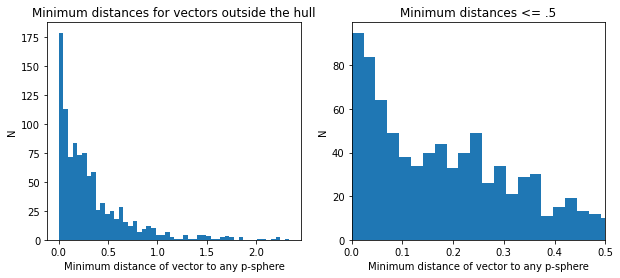

In [48]:
# Code to generate figure
fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(121)
ax1.hist(outside_min_distances,bins=50);
ax1.set_xlabel('Minimum distance of vector to any p-sphere')
ax1.set_ylabel('N')
ax1.set_title('Minimum distances for vectors outside the hull')
ax2 = fig.add_subplot(122)
ax2.hist(outside_min_distances,bins=100);
ax2.set_xlabel('Minimum distance of vector to any p-sphere')
ax2.set_xlim((0,.5))
ax2.set_ylabel('N')
ax2.set_title('Minimum distances <= .5')

In [33]:
print('Indices of vectors inside the hull:')
print(points_inside)
print('Vector index, containing sphere label(s), & containing sphere densities:')
spheres_set = set()
for idx in points_inside:
    vector = newdata[idx,:]
    containing_spheres = hull.find_containing_spheres(vector)
    spheres_set.update(set(containing_spheres))
    densities = [hull.spheres[s].ndata / hull.spheres[s].pcylinder_vol for s in containing_spheres]
    print(idx, containing_spheres, densities)

Indices of vectors inside the hull:
[  2 200 349 504 683]
Vector index, containing sphere label(s), & containing sphere densities:
2 (8,) [3.96552779963023e-06]
200 (13,) [1.897759297331412e-05]
349 (13,) [1.897759297331412e-05]
504 (29,) [8.383099790887179e-06]
683 (8,) [3.96552779963023e-06]


In [34]:
# Dataframe for the p-spheres containing the new data.
spheres_df.loc[list(spheres_set)]

,ndata,localdim,radius,ps_volume,ps_vratio,ps_density,hc_volume,hc_vratio,hc_density,ps_to_hc
cluster,,,,,,,,,,
8,13,4,5.949152,3.278252e+06,0.001488,0.000004,20435.764658,0.000009,0.000636,160.417395
29,14,2,9.227604,1.670027e+06,0.000758,0.000008,4419.293466,0.000002,0.003168,377.894488
13,29,5,4.601661,1.528118e+06,0.000693,0.000019,36020.159380,0.000016,0.000805,42.423963


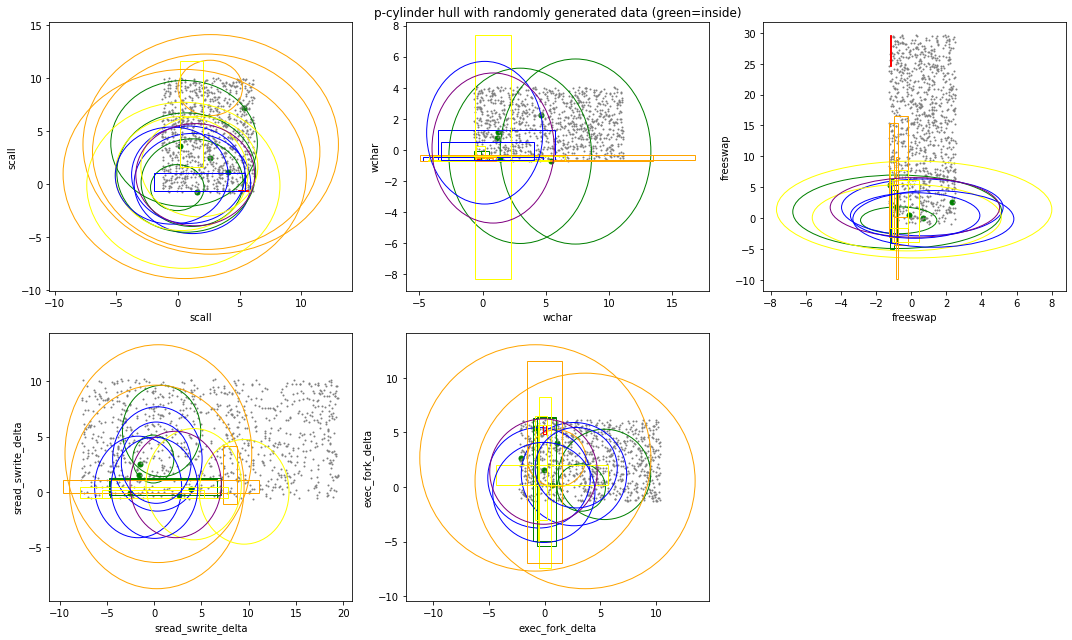

In [35]:
# Code to draw the hull in three 2D projections, using only non-redundant domains
fig = plt.figure(figsize=(15,9))
idx = [[0,1],[2,3],[4,5],[6,7],[8,0]]

for iax in range(5):
    idx1 = idx[iax][0]
    idx2 = idx[iax][1]
    ax = fig.add_subplot(231 + iax)
    ax.set_xlabel(col_names[idx1])
    ax.set_ylabel(col_names[idx1])
    #ax.scatter(scaled_data[:,idx1], scaled_data[:,idx2], s=4, c='grey', alpha=0.5)
    ax.scatter(newdata[points_inside,idx1], newdata[points_inside,idx2], s=25, c='green')
    ax.scatter(newdata[points_outside,idx1], newdata[points_outside,idx2], s=1, c='grey')
    for k in range(hull.n_spheres):
        if hull.spheres[k].used:
            cyl, rect = rcs.pcylinder_patch(idx1, idx2, hull.spheres[k].center, hull.spheres[k].radius,
                                            hull.spheres[k].compact_dims, hull.spheres[k].compact_ranges, color=clus_cols[k])
            ax.add_patch(cyl)
    if iax == 1:
        ax.set_title('p-cylinder hull with randomly generated data (green=inside)')
fig.tight_layout()        

## Machine Learning with a P-Sphere Hull

### Traditional machine learning process

In [36]:
# Classification target is whether the server is supporting fewer than 80 users
binary_target = np.where(target <= 80, 1, 0)

# Reserve indexes 6000+ for interpolation/extrapolation tests after the training 
idx_split = 6000
X = scaled_data[:idx_split,:]
y = target[:idx_split]
ybin = binary_target[:idx_split]

# Random split with 20% for testing
Xtrain, Xtest, ytrain, ytest, ybin_train, ybin_test = train_test_split(X, y, ybin, train_size=0.8, random_state=42)

print(Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape, ybin_train.shape, ybin_test.shape)

cmodel = RandomForestClassifier(n_estimators=50, max_depth=None, n_jobs=3, random_state=42)
cmodel.fit(Xtrain, ybin_train)
ybin_pred = cmodel.predict(Xtest)
f1 = metrics.f1_score(ybin_test,ybin_pred)
print('RF Classifier F1 score:', f1)

rmodel = RandomForestRegressor(n_estimators=50, max_depth=None, n_jobs=3, random_state=42)
rmodel.fit(Xtrain, ytrain)
ypred = rmodel.predict(Xtest)
mae = metrics.mean_absolute_error(ytest,ypred)
print('RF Regressor MAE score:', mae)

(4800, 9) (1200, 9) (4800,) (1200,) (4800,) (1200,)
RF Classifier F1 score: 0.8024193548387096
RF Regressor MAE score: 2.3068


### Build a hull for the training dataset

Now let's examine the same machine learning problem from a different angle using the P-Sphere Hull.

First, we create a domain model for the training data. We reduce the number of clusters since we reduced the size of 
the dataset by 20%.

In [37]:
train_gm = GaussianMixture(50, random_state=99)
train_gm_labels = train_gm.fit_predict(Xtrain)
train_spheres_df = rcs.describe_cluster_pspheres(Xtrain, train_gm_labels, train_gm.means_)

Note: ps_density, ps_volume, ps_vratio, and ps_to_hc are using p-cylinder volumes


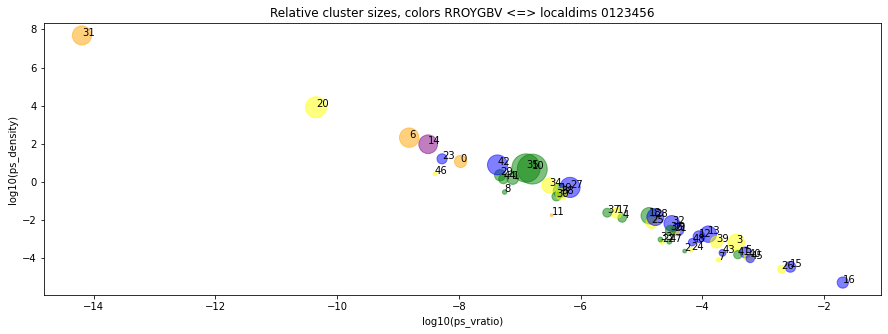

In [38]:
rcs.plot_cluster_pspheres(train_spheres_df, 6, 'ps_vratio', 'ps_density')

We see that cluster 16 has a very large volume, but looking at it in the widget below shows that the dimensions of the p-cylinder are appropriate. (The radius of the non-compact dimensions is large, but generally appropriate.) 

Therefore, let's try leaving the hull alone.

In [39]:
# code to prepare the widget
axmin = []
axmax = []
for icol in range(9):
    axmin.append(np.min(Xtrain[:,icol])-0.3)
    axmax.append(np.max(Xtrain[:,icol])+0.3)
lims = list(zip(axmin,axmax))
temp_hull = psh.PSphereHull(Xtrain, train_gm_labels, train_gm.means_)

def display_cluster_projections(cid):
    fig = plt.figure(figsize=(15,9))
    for iax in range(5):
        ix = iax * 2
        iy = (iax * 2 + 1) % 9
        ax = fig.add_subplot(231+iax)
        ax.set_xlim(lims[ix])
        ax.set_ylim(lims[iy])
        c_rows = np.where(train_gm_labels==cid)[0]
        ax.scatter(Xtrain[c_rows,ix],Xtrain[c_rows,iy],s=25,marker='x',color='black',lw=0.5)
        circ = plt.Circle((temp_hull.spheres[cid].center[ix], temp_hull.spheres[cid].center[iy]),
                              radius=temp_hull.spheres[cid].radius, color=clus_cols[cid], fill=False)
        cyl, rect = rcs.pcylinder_patch(ix, iy, temp_hull.spheres[cid].center, temp_hull.spheres[cid].radius, 
                                        temp_hull.spheres[cid].compact_dims, temp_hull.spheres[cid].compact_ranges, color='black')
        if rect: 
            ax.add_patch(cyl)
        ax.add_patch(circ)
        ax.set_title('Cluster '+str(cid))
        ax.set_xlabel(col_names[ix])
        ax.set_ylabel(col_names[iy])
    plt.show()
    return

inbox = widgets.BoundedIntText(value=0, min=0, max=spheres_df.shape[0], description='Cluster ID:')
ui = widgets.HBox([inbox])
out = widgets.interactive_output(display_cluster_projections, {'cid': inbox})
display(ui,out);

Output()

Now we can create the hull. Although below, we see that it is finally described by only 22 p-cylinders, even though we produced it from a solution with 50 clusters.

In [40]:
%%time

train_hull = psh.PSphereHull(Xtrain, train_gm_labels, train_gm.means_)
train_hull.make_local_dimensions()
train_hull.make_pcylinders()
train_hull.flag_redundant_spheres()
used_spheres = [s.label for s in train_hull.spheres if s.used]
print('Using p-spheres:', used_spheres)

Using p-spheres: [2, 3, 4, 8, 11, 15, 16, 17, 21, 22, 24, 26, 32, 33, 34, 41, 42, 44, 46, 47, 48, 49]
Wall time: 3min 19s


In [41]:
train_spheres_df.loc[used_spheres]

,ndata,localdim,radius,ps_volume,ps_vratio,ps_density,hc_volume,hc_vratio,hc_density,ps_to_hc
cluster,,,,,,,,,,
2,8,4,3.292278e+00,3.384209e+04,5.098610e-05,2.363920e-04,1.554451e+03,2.341918e-06,5.146511e-03,2.177108e+01
3,157,3,9.470039e+00,2.373540e+05,3.575947e-04,6.614593e-04,3.417786e+02,5.149197e-07,4.593617e-01,6.944670e+02
4,41,4,3.520270e+00,3.179134e+03,4.789646e-06,1.289659e-02,2.855917e+02,4.302691e-07,1.435616e-01,1.113175e+01
8,11,4,2.472449e+00,3.742536e+01,5.638461e-08,2.939183e-01,2.115080e+00,3.186555e-09,5.200749e+00,1.769454e+01
11,4,2,5.055764e+00,2.206018e+02,3.323562e-07,1.813222e-02,2.842428e+01,4.282370e-08,1.407247e-01,7.761034e+00
15,65,5,4.967397e+00,1.840448e+06,2.772797e-03,3.531750e-05,5.703448e+04,8.592749e-05,1.139661e-03,3.226903e+01
16,71,5,5.423515e+00,1.339199e+07,2.017622e-02,5.301676e-06,8.677090e+04,1.307280e-04,8.182467e-04,1.543374e+02
17,60,3,6.010862e+00,2.581724e+03,3.889595e-06,2.324029e-02,1.832170e+02,2.760326e-07,3.274805e-01,1.409107e+01
21,65,3,4.328673e+00,2.299219e+04,3.463977e-05,2.827047e-03,1.695161e+02,2.553910e-07,3.834444e-01,1.356343e+02


### Classification results: in-domain vs ex-domain data

Now we come to a key step: for the test data, we check which points are in the hull. For the test dataset, only 19 points are out of domain with respect to the p-sphere hull of the training dataset. However, notice that we can measure the performance of the model on in-domain data and OOD data separately.

In [42]:
inside = train_hull.contains(Xtest)
indomain_Xtest = Xtest[inside]
indomain_ytest = ytest[inside]
indomain_ybin_test = ybin_test[inside]
exdomain_Xtest = Xtest[np.invert(inside)]
exdomain_ytest = ytest[np.invert(inside)]
exdomain_ybin_test = ybin_test[np.invert(inside)]
print('In-domain test shape:',indomain_ytest.shape)
print('Ex-domain test shape:',exdomain_ytest.shape)

In-domain test shape: (1181,)
Ex-domain test shape: (19,)


In [43]:
indomain_ybin_pred = cmodel.predict(indomain_Xtest)
exdomain_ybin_pred = cmodel.predict(exdomain_Xtest)
print('In-domain F-score:', metrics.f1_score(indomain_ybin_test, indomain_ybin_pred))
print('Ex-domain F-score:', metrics.f1_score(exdomain_ybin_test, exdomain_ybin_pred))

In-domain F-score: 0.7948717948717948
Ex-domain F-score: 0.9285714285714286


### Regression results: in-domain vs ex-domain data

In [44]:
indomain_ypred = rmodel.predict(indomain_Xtest)
exdomain_ypred = rmodel.predict(exdomain_Xtest)
print('In-domain MAE:', metrics.mean_absolute_error(indomain_ytest,indomain_ypred))
print('Ex-domain MAE:', metrics.mean_absolute_error(exdomain_ytest,exdomain_ypred))

In-domain MAE: 2.267908552074513
Ex-domain MAE: 4.724210526315792


The regression results are worse for ex-domain data, as expected. 

For in-domain data, let's see if prediction quality is related to the density of the p-sphere containing the data point.

P-sphere ID, P-sphere density
16 5.30167615317869e-06
26 2.6415388382959454e-05
15 3.531749665351797e-05
46 9.647439243620862e-05
42 0.00015425513672840259
44 0.00019068030468180616
2 0.00023639202572678202
24 0.0002770440162908363
3 0.0006614593373982171
49 0.0006905136753310293
48 0.0007403729029991138
33 0.0009601256413813362
21 0.002827046771440418
32 0.006681128531538378
4 0.012896594370167382
17 0.0232402880712918
8 0.2939183464847314
34 0.6545138730994338
47 2.6279412513630955


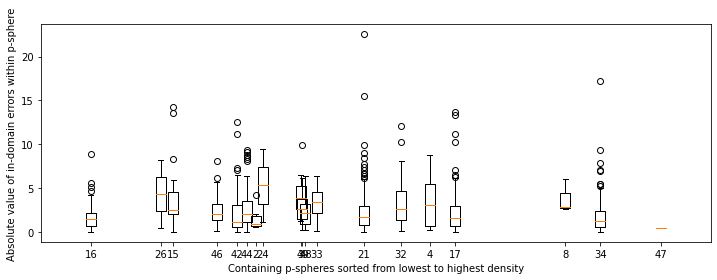

In [45]:
# Box plots of the in-domain (interpolation) errors for held-out points

def find_best_density(vector, hull):
    containing_spheres = hull.find_containing_spheres(vector)
    densities = [hull.spheres[s].ndata / hull.spheres[s].pcylinder_vol for s in containing_spheres]
    best_density = max(densities)
    best_sphere = containing_spheres[densities.index(best_density)]
    return best_sphere, best_density

data_spheres = [find_best_density(row,train_hull) for row in indomain_Xtest]
# label of the highest-density containing sphere for each point
spheres = np.array([x[0] for x in data_spheres])
# density of the highest-density containing sphere for each point
densities = np.array([x[1] for x in data_spheres])
# absolute errors associated with the in-domain points
errors = np.abs(indomain_ypred-indomain_ytest)

# list of lists collecting prediction errors within each sphere
err_vectors = []
sphere_densities = []
ids = []
for s in set(spheres):
    srows = np.where(spheres==s)[0]
    err_vectors.append(errors[srows])
    sphere_densities.append(train_hull.spheres[s].ndata / train_hull.spheres[s].pcylinder_vol)
    ids.append(s)
order = np.array(sphere_densities).argsort()
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(111)
ax.boxplot([err_vectors[i] for i in order], positions=np.log10([sphere_densities[i] for i in order]),
            labels=[ids[i] for i in order], widths=0.1);
ax.set_xlabel('Containing p-spheres sorted from lowest to highest density')
ax.set_ylabel('Absolute value of in-domain errors within p-sphere')

print('P-sphere ID, P-sphere density')
for i in order:
    print(ids[i], sphere_densities[i])

We can see that the prediction quality is not closely related to the p-sphere density. Outlier errors are found in most of the p-spheres, even though their densities range over several orders of magnitude.

For ex-domain data, we can ask whether the prediction quality is related to distance from the closest p-cylinder. Note that the
method `psphere_distances` gives the distances to all p-spheres in the hull, whether they are masked or not. It is possible that
an ex-domain vector is actually inside one of the masked p-spheres, so here to get the distances from the hull, I select only the columns corresponding to spheres that are used.

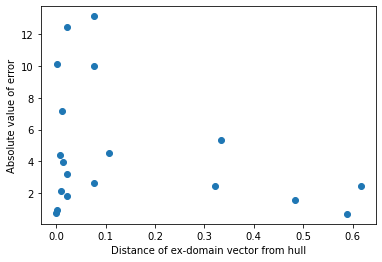

In [46]:
distances = train_hull.psphere_distances(exdomain_Xtest)
shortest_distances = np.min(distances[:,used_spheres], axis=1)
errors = np.abs(exdomain_ypred-exdomain_ytest)
plt.scatter(shortest_distances, errors)
plt.xlabel('Distance of ex-domain vector from hull')
plt.ylabel('Absolute value of error');

## Conclusion

This notebook has demonstrated a new approach to explainable and trusted AI that is suitable for traditional machine learning applications, where a predictive model is trained on historical data then enters production to immediately begin processing
new data. Rather than evaluating the model's overall performance and retraining periodically, I propose to explicitly model the
high-dimensional domain of the training dataset, and develop a supervision layer that raises a warning when the model is asked
for a prediction outside this domain. 

In this way the end users can receive __early warning of data drift and avoid using ex-domain predictions__, which are likely to be less reliable and potentially harmful to the business. This self-awareness on the part of a machine learning model also builds confidence that it understands the limits of its own training data. The simple machine learning application demonstrated at the end of the notebook confirms that ex-domain data are likely to have larger errors for a regression problem.

Like most clustering and segmentation algorithms, creating a good model for the training dataset's domain currently requires human supervision. Visualizing high-dimensional data is challenging at the best of times, but the `refine_cluster_set` module provides tools to help us understand which sub-domains are relatively compact, so that a p-sphere boundary is a good approximation, and
which sub-domains are sparse, extended or low-dimensional.

In [47]:
%watermark -u -n -t -z

Last updated: Mon Sep 27 2021 23:34:42Paris, Madrid (heure d’été)

